# Building A Better Dish Finder (Clustering Users)

## The goal of the project is to build an app that allows a user to find local resturants and eateries that specialize in a specific dish. This could be anything - bagels, pizza, chicken wings, tacos. We are looking to redefine what it means for a resturant to be "good", as many resturants specialize in certain dishes.

## The dataset can be found at https://www.yelp.com/dataset.

In [1]:
import numpy as np
import time
import scipy
import pandas as pd
import dask.bag as db
import json
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import mplleaflet
import folium
import random
from folium.plugins import MarkerCluster
from scipy.special import factorial as factorial
%matplotlib notebook
pd.set_option('display.max_columns', None)

## Here we will focus on a specific data set, the Toronto data, and work to increase the speed of the bayseian inferance


In [2]:
Toronto = pd.read_csv('toronto.csv')

# Clustering (7/14/20)

## The first order of business is to simplify the business id and the user id for the purposes of clustering. This will make sorting significantly easier

In [9]:
busid = Toronto.sort_values('business_id')['business_id'].unique()

In [11]:
busid = Toronto.sort_values('business_id')['business_id'].unique()
simpid_dict = {}
count = 0
for value in busid:
    simpid_dict.update({value: count})
    count+=1
Toronto['simid'] = Toronto['business_id'].map(simpid_dict)
usid = Toronto.sort_values('user_id')['user_id'].unique()
simpid_dict = {}
count = 0
for value in usid:
    simpid_dict.update({value: count})
    count+=1
Toronto['usid'] = Toronto['user_id'].map(simpid_dict)

In [13]:
usid = Toronto.sort_values('user_id')['user_id'].unique()
simpid_dict = {}
count = 0
for value in usid:
    simpid_dict.update({value: count})
    count+=1
Toronto['usid'] = Toronto['user_id'].map(simpid_dict)

## We can now see that each business has a simple id (simid), and that each reviewer has a user id (usid)

In [14]:
Toronto

,Unnamed: 0,address,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,stars_x,state,cool,date,funny,stars_y,text,user_id,simid,usid
0,27,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2012-09-11 04:15:13,0,5,"i love this service, a client had referred me ...",Dl6Y6sjVGL7br1O44rXDQg,123,18425
1,28,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2013-10-31 16:08:34,0,5,i have been with fdo for a year now and i love...,AHXy4uTg_L8VFXNRufLYdQ,123,14150
2,29,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,2,2010-09-11 11:50:58,0,4,"you know, i think i was in a super-good mood w...",TaJ3hRYUW9Z82HF0qc4hFQ,123,38217
3,30,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2015-05-20 22:43:50,0,5,"this company is flexible, caring, and committe...",9sDNyyANgUMNg0RsuR0E7A,123,13677
4,31,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2010-08-09 23:51:42,0,5,they can 'splain it better than me. from thei...,TaJ3hRYUW9Z82HF0qc4hFQ,123,38217
5,32,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2011-10-24 23:04:57,1,4,i've been using this delivery service for almo...,VVm-TFCpi9M1-k8ED0l1eA,123,40582
6,33,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2011-04-16 14:49:40,0,4,"update:\nmy review on this was filtered, so th...",9nk02in9hJoQnEHibZUPmQ,123,13585
7,34,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,3,2011-10-26 15:17:28,0,4,"so far so good, they have treated me well even...",jxb9KT_xTYFExhFQXC1wdw,123,59784
8,35,415 Horner Avenue,007Dg4ESDVacWcC4Vq704Q,"Shopping, Food, Organic Stores, Specialty Food...",Toronto,"{'Monday': '9:0-16:0', 'Tuesday': '9:0-16:0', ...",0,43.603232,-79.538424,Front Door Organics,M8W 4W3,4.0,ON,0,2011-04-29 12:58:33,0,1,front door organics produce is appalling!!! i...,NoHJq8geM3gVCxMUoj_rXA,123,31014
9,75,843 Kipling Avenue,rVBPQdeayMYht4Uv_FOLHg,"Restaurants, Burgers, Food",Toronto,NaN,0,43.633291,-79.531768,Gourmet Burger Company,M8Z 5G9,3.0,ON,0,2011-07-29 16:00:02,1,5,"we've eaten here a few times now, and have bee...",zsZVg16yjZu5NIiS0ayjrQ,6177,79860


## The number of reviews is absolutely massive - there are about 7 thousand resturants, and 80 thousand individual reviewers. The task is to find some correlation between reviewers, so that we can cluster them. Reviewers who agree on resturant scores should be correlated, while those who disagree should be negativly correlated. We then look at what the average correlation is between users

In [17]:
# Not in use now, but potentially useful later
def resturant_dot_product(vec1,vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    matrix = np.array([[1,.5,0,-.5,-1],[.5,1,.5,0,-.5],[0,.5,1,.5,0],[-.5,0,.5,1,.5],[-1,-.5,0,.5,1]])
    return np.dot(np.dot(matrix,vec1),vec2)
##


def resturant_value(stars1,stars2):
    diffstars = abs(stars2-stars1)
    if diffstars == 0:
        return 1
    elif diffstars == 1:
        return .5
    elif diffstars == 2:
        return 0
    elif diffstars == 3:
        return -.5
    elif diffstars == 4:
        return - 1

In [12]:
from scipy.sparse import lil_matrix
matrix3 = lil_matrix((len(usid),len(usid)))

for k in range(len(busid)):
    users, stars = Toronto[Toronto['simid'] == k]['usid'].to_list(), Toronto[Toronto['simid'] == k]['stars_y'].to_list()
    for i in range(len(users)):
        for j in range(len(users)):
            if i != j:
                matrix3[users[i],users[j]] += resturant_value(stars[i],stars[j])
    

## Now that we have our matrix, we want to find all connections between reviewers, and also find what the weight of each connection is

In [13]:
a = matrix3.nonzero()[0]
b = matrix3.nonzero()[1]
G = []
for i in range(len(a)):
    G.append(matrix3[a[i],b[i]])
edges = np.array([a,b]).T

## Additionally, we want a map to be able to quickly look up, for a given reviewer, all of the edges it is involved in

In [14]:
index_map = []
listofusers = edges.T[0]
count = 0
for k in range(len(usid)):
    switch = False
    indexes = []
    
    while switch == False:
        if count > len(listofusers)-1:
            index_map.append(indexes)
            switch = True
        elif listofusers[count] == k:
            indexes.append(count)
            count += 1
        else:
            index_map.append(indexes)
            switch = True


## Finally, we can transform the weights to be from -1 to 1 using an arctan function

In [15]:
G_arctan = np.arctan(G)/(np.pi/2)

# The following are a number of attempts to generate good clusters. The first is a custom clustering algorithm based on a modified correlation clustering algorithm. It first seeds a cluster by picking a random reviewer from the list, and finding all edges. It then calculates for each reviewer in the cluster, what the "force" binding it to the rest of the cluster is. If the force is below a certain threshold, it is kicked out. We then resample a reviewer from the cluster, and again draw in all reviewers it is connected to. After several iterations, we wind up with a stable cluster that can accept no more reviewers, and we move on to the next cluster (which will likely not have as high correlation #

In [150]:
def cluster(C,pointsleft,edges_a,G_arctan,mapindex,seed):
    i = random.choice(C)
    cluster = [i]
    V = []
    edgeindexes = mapindex[i]
    for edge in edgeindexes:
        if np.array(edges_a[edge]).T[1] in pointsleft:
            if G_arctan[edge] > 0:
                if np.random.uniform(0,1) < G_arctan[edge]:
                    cluster.append(np.array(edges_a).T[1][edge])
            
            #else:
            #    if np.random.uniform(0,1) < abs(G_arctan[edge]):
            #        V.append(edges.T[1][edge])
    if seed == True:
        return cluster
    else:
        cluster = np.append(C,cluster)
        return cluster

def Cforce_calc(C,edges,mapindex):
    Cforce = []
    for cval in C:
        alledges = mapindex[cval]
        force = 0
        for edge in alledges:
            if edges[edge].T[1] in C:
                force += G_arctan[edge]
        Cforce.append(force)
    return Cforce

def makeclusters(edges,users,G_arctan,mapindex):
    points = users[:]
    first = True
    pointsleft = True
    clusters = []
    while pointsleft:
        C = cluster(points,points,edges,G_arctan,mapindex,seed=True)
        C = np.sort(C)
        Cforce = Cforce_calc(C)
        
        if len(C) > 2:
            C = np.unique((np.array(Cforce) > (max(Cforce) + min(Cforce))/4) * C)
                
        for i in range(5):
            C = cluster(C,points,edges,G_arctan,mapindex,seed=False)
            C = np.sort(C)
            if len(C) > 2:
                Cforce = Cforce_calc(C)
                C = np.unique((np.array(Cforce) > (max(Cforce) + min(Cforce))/4) * C)
        clusters.append(C)
      
        points = [ele for ele in points if ele not in C]
  
        print(len(points))
        if len(points) < 5:
            pointsleft = False
    return clusters

### Here, we look at a subset of the review data, which mention arepas

In [502]:
points = Toronto[Toronto['text'].str.contains('arepa',regex=True)].usid.to_list()

In [505]:
newedges = []
newG = []
for cval in points:
    alledges = [index_map[cval]]
    alledges = [item for sublist in alledges for item in sublist]
    
    
    for i in range(len(alledges)):
        if edges[alledges[i]][1] in points:
            newedges.append(list(edges[alledges[i]]))
            newG.append(G_arctan[alledges[i]])


In [506]:
new_index_map = []
listofusers = np.array(newedges).T[0]
count = 0
for k in range(len(usid)):
    switch = False
    indexes = []
    
    while switch == False:
        if count > len(listofusers)-1:
            new_index_map.append(indexes)
            switch = True
        elif listofusers[count] == k:
            indexes.append(count)
            count += 1
        else:
            new_index_map.append(indexes)
            switch = True

In [507]:
newmatrix = np.zeros((len(points),len(points)))
i = 0
for point in points:
    newmatrix[i,i] = 1
    edges_to_check = new_index_map[point]
    for edge in edges_to_check:
        j = list(points).index(newedges[edge][1])
        newmatrix[i,j] = newG[edge]
    i += 1

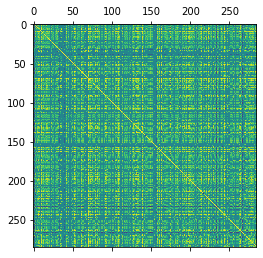

In [508]:
plt.matshow(newmatrix)

In [467]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
   
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [509]:
cluster_matrix = cluster_corr(newmatrix,inplace=False)

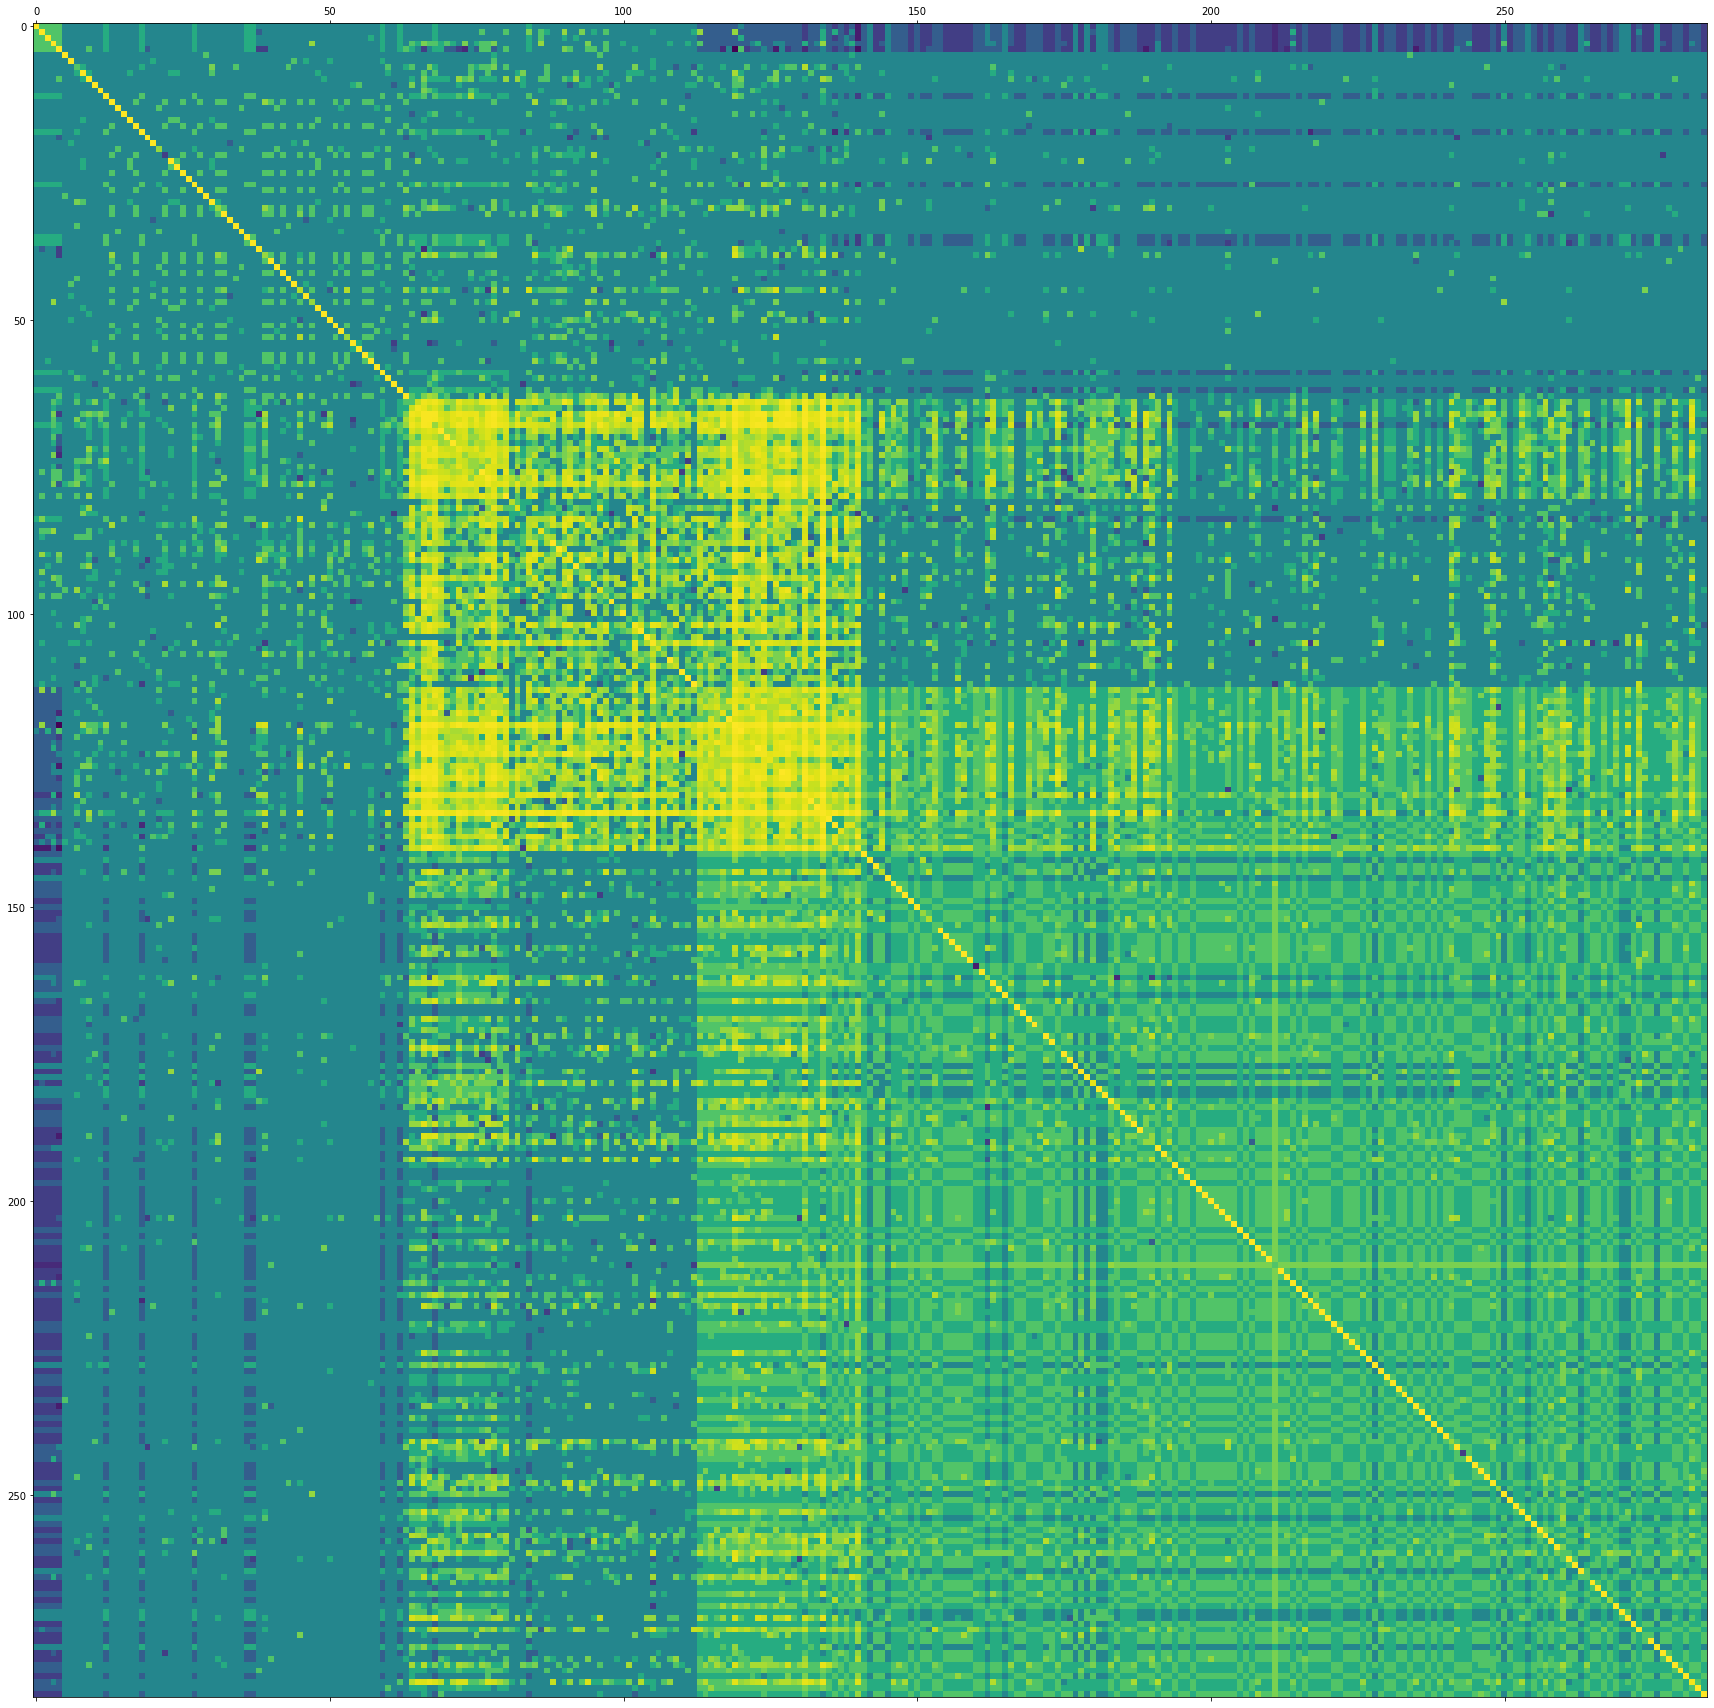

In [510]:
plt.figure(figsize=(30,30))
plt.matshow(cluster_matrix,fignum=1)


## We can see that through this hierarchical clustering algorthim of a small portion of the data, there are some large custers present, but not smaller clusters which would indicate usability. It may be nessisary to go back and redefine how we correlate users

## We also can try to use a force simulation approach, both homemade and out of the box (networkx)

In [162]:
def getdistvec(edges,pos):
    return np.sqrt(sum(((pos[edges.T[0]] - pos[edges.T[1]])**2).T))

def getunitvector(edges,pos):
    xcomp = ((pos[edges.T[1]] - pos[edges.T[0]])).T[0] / getdistvec(edges,pos)
    xcomp = np.nan_to_num(xcomp)
    ycomp = ((pos[edges.T[1]] - pos[edges.T[0]])).T[1] / getdistvec(edges,pos)
    ycomp = np.nan_to_num(ycomp)
    return (xcomp,ycomp)


def step(pos,nodes,edges,G,index_map):
    G = np.array(G)
    distvec = getdistvec(edges,pos)
    distvec = (distvec <= .01)*.01 + (distvec > .01)*distvec
    xcomp,ycomp = getunitvector(edges,pos)
    
    force =  G*(distvec)*(G>0) + 10*G*(1/abs(distvec))**2 *(G<0) 
    
    
    forcex = force*xcomp
    forcey = force*ycomp
    
    
    
    sumforcex,sumforcey = np.zeros(len(nodes)),np.zeros(len(nodes))
    for val in np.unique(edges.T[0]):
        sumforcex[val],sumforcey[val] = sum(forcex[index_map[val]]),sum(forcey[index_map[val]])
    
    
    #totalforce = np.sqrt(sumforcex**2 + sumforcey**2)
    #sumforcexcomp,sumforceycomp = (sumforcex/totalforce), (sumforcey/totalforce)
    #sumforcexcomp,sumforceycomp = np.nan_to_num(sumforcexcomp), np.nan_to_num(sumforceycomp)
    
    #totalforce = (totalforce >= 1000)*1000 + (totalforce < 1000)*totalforce
    #sumforcex,sumforcey = sumforcexcomp*totalforce, sumforceycomp*totalforce    
    
    
    pos.T[0] += .001*sumforcex + np.random.normal(0,.1,len(pos.T[0]))
    pos.T[1] += .001*sumforcey + np.random.normal(0,.1,len(pos.T[1]))

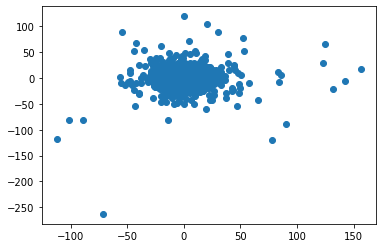

In [30]:
startpos = np.array([np.random.normal(0,1,len(usid)),np.random.normal(0,1,len(usid))]).T
for i in range(2):
    step2(startpos,usid,edges,G_arctan,index_map)
plt.plot(startpos.T[0],startpos.T[1],'o')

In [359]:
import networkx as nx

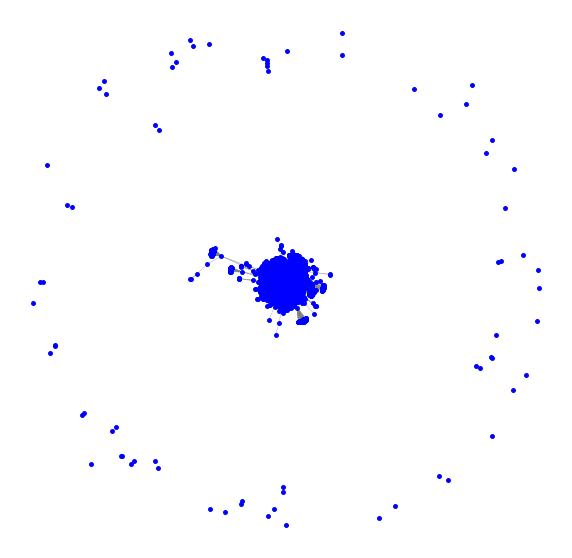

In [394]:
G = nx.Graph()
G.add_nodes_from(unique_nodes)
G.add_edges_from(pruned_edges)
pos = nx.spring_layout(G)
plt.rcParams['figure.figsize'] = [10, 10]
nx.draw_networkx(G, pos = pos, with_labels=False, 
                 node_size=15, width=0.3, node_color='blue', edge_color='grey')
limits=plt.axis('off') # turn of axis

## We can see the out of the box networkx tool is not doing a good job clustering our network. Will require more thought